In [19]:
import pandas as pd
import os
import urllib.request
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re


In [20]:

# Инициализация WebDriver
driver = webdriver.Chrome()
driver.execute_script("Object.defineProperty(navigator, 'userAgent', {value: 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'});")

url = 'https://www.tsum.ru/'

df = pd.DataFrame(columns=['page_url',
                           'image_url',
                           'images_close_url',
                           'saved_image',
                           'name',
                           'cat_1',
                           'cat_2',
                           'cat_3',
                           'brand',
                           'price',
                           'color',
                           'description'])


In [21]:

pages = 2
img_count = 0
count = 0
save_counter = 0
save_interval = 100
driver.get(url)

# Ждем, пока элемент на странице не станет видимым
wait = WebDriverWait(driver, 1)
element = wait.until(EC.visibility_of_element_located((By.TAG_NAME, 'body')))

# Получите содержимое страницы
catalog_soup = BeautifulSoup(driver.page_source, 'html.parser')

# найдем категории
chapters = catalog_soup.find('div', class_="style__nav___QCTH8").find('ul', class_='style__list___XCoyx')

catalogs, catalogs_name = [], []
for chapter in chapters:
    catalogs.append(url + chapter.find('a').get('href')[1:])
    catalogs_name.append(chapter.find('a').text)

catalogs = catalogs[3:4] #2 одежда, 3 обувь, 4 сумки, 5 аксы
catalogs_name = catalogs_name[3:4] #2 одежда, 3 обувь, 4 сумки, 5 аксы

for n in range(len(catalogs_name)):
    catalog = catalogs[n]
    driver.get(catalog)
    element = wait.until(EC.visibility_of_element_located((By.TAG_NAME, 'body')))
    sub_catalog = BeautifulSoup(driver.page_source, 'html.parser')

    cat = sub_catalog.find_all('li', class_="style__filtersItem___oY3b3")

    for cat_ in range(0, len(cat)):
        driver.get(url + cat[cat_].find('a').get('href')[1:])
        cat_text = cat[cat_].find('a').text  # тип подкатегории (платье, брюки, юбки)
        element = wait.until(EC.visibility_of_element_located((By.TAG_NAME, 'body')))
        cat_soup = BeautifulSoup(driver.page_source, 'html.parser')
        cat_clother = cat_soup.find_all('li', class_="style__dropdownItem____DaHS style__dropdownItemFlags___W3E7Q")

        for clother_ in cat_clother:
            clother = url + clother_.find('a').get('href')[1:]
            clother_name = clother_.find('a').text  # подраздел подкатегории товара (платье: повседневное, вечернее, классическое)
            driver.get(clother)
            element = wait.until(EC.visibility_of_element_located((By.TAG_NAME, 'body')))
            clot_soup = BeautifulSoup(driver.page_source, 'html.parser')
            pages = int(clot_soup.find_all('div', class_="styles_paginationWrapper__6378cbe9")[-1].find_all('a')[-1].text)

            # for page in range(1, pages):
            driver.get(clother + f'?page={1}') #одну стр пока взяла, но похоже где-то тут цикл полетел
            element = wait.until(EC.visibility_of_element_located((By.TAG_NAME, 'body')))
            page_soup = BeautifulSoup(driver.page_source, 'html.parser')
            clot_s = page_soup.find_all('div', class_="style__header___j2thV")

            for clother_unit in clot_s:
                clother_unit = clother_unit.find('a').get('href')[1:]
                url_unit = url + clother_unit
                driver.get(url_unit)
                element = wait.until(EC.visibility_of_element_located((By.TAG_NAME, 'body')))
                unit_soup = BeautifulSoup(driver.page_source, 'html.parser')
                span_tag = unit_soup.find('h1', class_="styles__productName___t3vA6")
                info = unit_soup.find('div', class_="style__section___WXcES style__sectionInfo___z6XFE")

                try:
                    description = info.find('p').text
                except AttributeError:
                    continue

                try:
                    brand = span_tag.find('span').text
                except AttributeError:
                    brand = None

                try:
                    name = span_tag.text.replace(brand + ' ', '')
                except AttributeError:
                    name = None

                try:
                    price = unit_soup.find('p', class_="style__price___l9Hm2").text
                except AttributeError:
                    price = None

                try:
                    color = unit_soup.find('span', class_="style__colorTitle___KEzNX").text
                except AttributeError:
                    color = None

                try:
                    imgs = unit_soup.find('div', class_="slick-track").find_all('img')
                    directory = f'./{catalogs_name[n]}/{cat_text}/{clother_name}'
                    if not os.path.exists(directory):
                        os.makedirs(directory)
                    image_url = imgs[4].get('src') #4 для обуви и сумок, 0 для одежды
                    image_url_s = imgs[6].get('src') # 6 для обуви и сумок, 3 для одежды
                    path_s = f'{directory}/{img_count}.jpg'
                    img_count += 1
                    urllib.request.urlretrieve(image_url_s, path_s)
                except AttributeError:
                    continue

                temp_df = pd.DataFrame({
                    'page_url': url + clother_unit,
                    'image_url': image_url,
                    'images_close_url': image_url_s,
                    'saved_image': path_s,
                    'name': name,
                    'cat_1': catalogs_name[n],
                    'cat_2': cat_text,
                    'cat_3': clother_name,
                    'brand': brand,
                    'price': re.sub(r'[\xa0\\]', '', price),
                    'color': color,
                    'description': description
                }, index=[0])

                df = pd.concat([df, temp_df], ignore_index=True)
                count += 1
                save_counter += 1
                if save_counter % save_interval == 0:
                        save_filename = f'fashion_{save_counter}.csv'
                        df.to_csv(save_filename, index=False)

# Закрытие WebDriver
driver.quit()


IndexError: list index out of range

<html lang="ru"><head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1, maximum-scale=1" name="viewport"/>
<title data-rh="true">Женские белые кожаные кеды oversized ALEXANDER MCQUEEN  купить в интернет-магазине ЦУМ, арт. 611698/WHX98</title>
<meta content="Женские белые кожаные кеды oversized ALEXANDER MCQUEEN, арт. 611698/WHX98 купить в интернет-магазине ЦУМ. Экспресс доставка, подарочная упаковка." data-rh="true" name="description"/><meta content="Женские белые кожаные кеды oversized Alexander McQueen интернет магазин купить" data-rh="true" name="keywords"/><meta content="Женские белые кожаные кеды oversized ALEXANDER MCQUEEN, арт. 611698/WHX98 купить в интернет-магазине ЦУМ. Экспресс доставка, подарочная упаковка." data-rh="true" property="og:description"/><meta content="product" data-rh="true" property="og:type"/><meta content="https://st2.tsum.com/sig/46f4051ec07729614e0f9f0caddcc6b4/width/1526/i/cf/c4/70/34/cfc47034-810e-387e-bff0-71544d369a68.jpg" dat
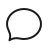

In [29]:
unit_soup

In [30]:
df

,page_url,image_url,images_close_url,saved_image,name,cat_1,cat_2,cat_3,brand,price,color,description
0,https://www.tsum.ru/product/6014907-kozhanye-k...,https://st2.tsum.com/sig/99f0686a456d796520934...,https://st1.tsum.com/sig/63c63ef39902173e01b62...,./Обувь/Кроссовки и кеды/Кеды/0.jpg,Кожаные кеды,Обувь,Кроссовки и кеды,Кеды,Jil Sander,64250₽,Желтый,"Мастера марки, основанной Джил Сандер, выполни..."
1,https://www.tsum.ru/product/6039760-kozhanye-k...,https://st1.tsum.com/sig/f3895e40cf3746bd3df1e...,https://st1.tsum.com/sig/4ecee35c7d4d863149db2...,./Обувь/Кроссовки и кеды/Кеды/1.jpg,Кожаные кеды Oversized,Обувь,Кроссовки и кеды,Кеды,Alexander McQueen,79900₽,Белый,Сара Бертон добавила знаковым белым кедам Over...
2,https://www.tsum.ru/product/5651615-kozhanye-k...,https://st1.tsum.com/sig/4dfe85fe1ae7b7a43e717...,https://st1.tsum.com/sig/50f8fdd41626387f4bb98...,./Обувь/Кроссовки и кеды/Кеды/2.jpg,Кожаные кеды Roma,Обувь,Кроссовки и кеды,Кеды,Dolce & Gabbana,67850₽,Белый,"Белоснежные кеды Roma, для пошива которых Доме..."
3,https://www.tsum.ru/product/5388389-kombinirov...,https://st1.tsum.com/sig/0b7c820a67be36f7442f1...,https://st1.tsum.com/sig/201670f333fcac85a7c8c...,./Обувь/Кроссовки и кеды/Кеды/3.jpg,Комбинированные кеды Replica,Обувь,Кроссовки и кеды,Кеды,Maison Margiela,59950₽,Бежевый,"На создание кедов Replica, впервые появившихся..."
4,https://www.tsum.ru/product/he00829646-tekstil...,https://st.tsum.com/btrx/i/13/27/44/94/01_1526...,https://st.tsum.com/btrx/i/13/27/44/94/02_237....,./Обувь/Кроссовки и кеды/Кеды/4.jpg,Текстильные кеды Tennis 1977,Обувь,Кроссовки и кеды,Кеды,Gucci,71820₽,Светло-желтый,При создании кедов Tennis 1977 Алессандро Мике...
...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://www.tsum.ru/product/5505219-kozhanye-k...,https://st2.tsum.com/sig/602b6223291e70b78135e...,https://st2.tsum.com/sig/2648c1f10165dfb544191...,./Обувь/Кроссовки и кеды/Кроссовки/95.jpg,Кожаные кроссовки Play,Обувь,Кроссовки и кеды,Кроссовки,Loro Piana,97350₽,Светло-голубой,"В весенне-летнюю коллекцию марки, основанной П..."
96,https://www.tsum.ru/product/5563216-kozhanye-k...,https://st2.tsum.com/sig/0db7a7e09f73cf8593933...,https://st1.tsum.com/sig/df1b272912b5263edf19e...,./Обувь/Кроссовки и кеды/Кроссовки/96.jpg,Кожаные кроссовки VL7N,Обувь,Кроссовки и кеды,Кроссовки,Valentino,87350₽,Молочный,В весенне-летней коллекции силуэт кроссовок VL...
97,https://www.tsum.ru/product/5555859-tekstilnye...,https://st2.tsum.com/sig/061390c8210291eb481e1...,https://st2.tsum.com/sig/7a0a9ef94c029d35047f9...,./Обувь/Кроссовки и кеды/Кроссовки/97.jpg,Текстильные кроссовки Wade Runner,Обувь,Кроссовки и кеды,Кроссовки,Valentino,83500₽,Фуксия,Пьерпаоло Пиччоли превратил кроссовки Wade Run...
98,https://www.tsum.ru/product/5567541-tekstilnye...,https://st1.tsum.com/sig/a9f3413669d233d56b92f...,https://st1.tsum.com/sig/1efe2d755f6a5f1a526f8...,./Обувь/Кроссовки и кеды/Кроссовки/98.jpg,Текстильные кроссовки Jago,Обувь,Кроссовки и кеды,Кроссовки,Tom Ford,87450₽,Белый,Легкие белые кроссовки Jago с неопреновым элас...


In [28]:
folder_path = '../Personal-Shopper/csv/'  #


csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]


merged_df = pd.DataFrame()


for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    merged_df = pd.concat([merged_df, df], ignore_index=True)


merged_file_path = '../Personal-Shopper/csv/merged.csv' 
merged_df.to_csv(merged_file_path, index=False)
